In [3]:
import re
import random
import pandas as pd
import hashlib

In [4]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate', 'Jane Eyre, Bronte']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [5]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
CCH Axcess,242.778096,8.371658,21.297813,29
Pandas,264.452433,29.383604,41.603785,9
"Jane Eyre, Bronte",382.422803,54.631829,134.926725,7
DAX,447.664606,49.740512,132.171801,9
Logging in Python,571.218685,71.402336,208.781566,8
Azure Private DNS,726.682983,80.742554,184.557021,9
Terraform,956.292813,79.691068,263.935116,12
Microsoft Purview,1074.802632,22.391722,41.508928,48
Azure AD Authentication,1102.745067,91.895422,153.773019,12
Azure Functions + PP365,1257.784804,78.611550,239.534596,16


# Histogram

sum of ages: ~49340.01


<Axes: >

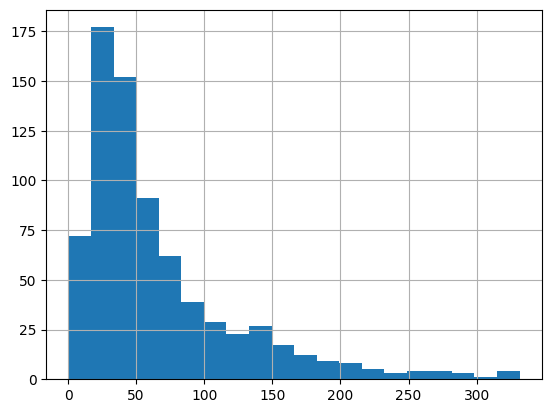

In [6]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~49340.01


<Axes: >

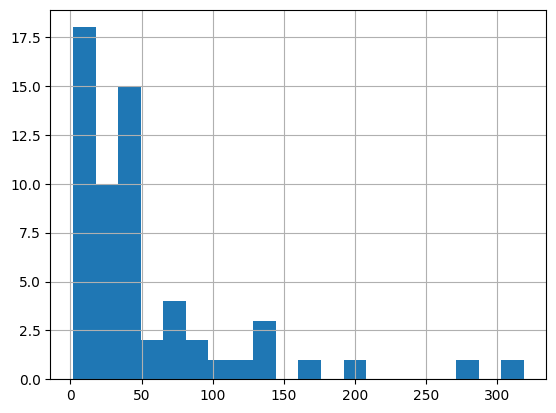

In [7]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Azure Developer Associate']['age'].hist(bins=20)

# Completely Random Shuffle

In [8]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [9]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [10]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [11]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [12]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [13]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [14]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [15]:
# n=3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [16]:
n=3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 742
Total card age: 49340.01


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
25,Azure DevOps Pipelines,"In Azure DevOps, what is the use of the strate...",22834b179fc5b8002c41682d03a4bac2,-315.725728,-100.343337,315.725728,2408.240089,0.359338,24,0,0
26,Azure DevOps Pipelines,What is the main purpose of a YAML file in Azu...,46bbb20c74c797870ae1f9d33b014c13,-210.161132,-100.343337,315.725728,2408.240089,0.359338,24,3,0
289,Azure DevOps Pipelines,How can you specify which agent pool should be...,fd84363503b4e901e4c25a290383d49a,-98.880359,-100.343337,315.725728,2408.240089,0.359338,24,6,0
28,Azure DevOps Pipelines,What does the 'trigger' keyword do in an Azure...,06fba7fd6798bc1228a14886c0d8a575,-87.748451,-100.343337,315.725728,2408.240089,0.359338,24,9,0
29,Azure DevOps Pipelines,How do you specify a condition for a job or st...,1fd0f7e5ad1a692e5f1c5587c6fb00c9,-59.030283,-100.343337,315.725728,2408.240089,0.359338,24,12,0
30,Azure DevOps Pipelines,What keyword is used to define multiple steps ...,dc54ec5cdb26dd55d483365541394665,-51.788477,-100.343337,315.725728,2408.240089,0.359338,24,15,0
32,Azure DevOps Pipelines,What does the resources keyword define in a YA...,14ecc75142b325834c4baa15828b31a5,-36.944671,-100.343337,315.725728,2408.240089,0.359338,24,18,0
543,Azure DevOps Pipelines,What does the trigger keyword do in an Azure D...,a097384f075f0b7c7dc948ba0445fbf7,-25.825055,-100.343337,315.725728,2408.240089,0.359338,24,21,0
0,Asynchronous Python,asyncio.gather()\nRuns multiple asynchronous P...,88e88ee301ac734f3b1f136e405d3cfd,-331.507049,-96.767133,331.507049,3967.452440,0.824823,41,0,0
1,Asynchronous Python,Throttling\nLimiting concurrency in Python asy...,6d8d6c93bede788bb645c334badc4faa,-252.753750,-96.767133,331.507049,3967.452440,0.824823,41,3,0


## Age Max

In [17]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [18]:
# n=5
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [19]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [20]:
if existing_cards.age.sum() < 0:
    asc = True
else: asc = False
existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
0,Asynchronous Python,asyncio.gather()\nRuns multiple asynchronous P...,88e88ee301ac734f3b1f136e405d3cfd,-331.507049,-96.767133,331.507049,3967.452440,0.824823,41,0,0
14,C# Basics,What’s the difference between delegates and ev...,aafda82832da4aaff149c8153e06fc0a,-327.957905,-84.176872,327.957905,2525.306170,0.165244,30,0,0
72,Azure Developer Associate,You need to deploy an Azure Files share along ...,932245130addc67369d5402942504c81,-318.611500,-53.192186,318.611500,3191.531167,0.722638,60,0,0
25,Azure DevOps Pipelines,"In Azure DevOps, what is the use of the strate...",22834b179fc5b8002c41682d03a4bac2,-315.725728,-100.343337,315.725728,2408.240089,0.359338,24,0,0
33,FSLogix,"Cloud Cache uses the concept of a proxy file, ...",78203bab9238f47ee752697bba4135a5,-305.111606,-83.484366,305.111606,2588.015332,0.576818,31,0,0
333,Azure Developer Associate,A company has an App Service web app that requ...,786eb611c1ad4b131a5b90871a4e2fd8,-286.883737,-53.192186,318.611500,3191.531167,0.722638,60,1,1
263,Asynchronous Python,asyncio.wait_for()\nRuns a coroutine with a ti...,0ccadcbce46e58eb4de4907f7e86cbf9,-285.023435,-96.767133,331.507049,3967.452440,0.824823,41,1,1
287,Azure DevOps Pipelines,What is the default working directory for a pi...,4874a140413af48140b5cb984340bd62,-284.691916,-100.343337,315.725728,2408.240089,0.359338,24,1,1
537,Azure DevOps Pipelines,How can you pass secrets securely in Azure Dev...,5b00153ed3bdf8955aa08ad4e2779a5c,-281.035681,-100.343337,315.725728,2408.240089,0.359338,24,2,2
514,Asynchronous Python,async with (async context manager)\nManages as...,359a45c84a774bead164891fd0454b3c,-278.783331,-96.767133,331.507049,3967.452440,0.824823,41,2,2


In [21]:
existing_cards['age'].mean()

-66.4959711499081